In [1]:
import gymnasium as gym

import os
import sys

if "SUMO_HOME" in os.environ:
    tools = os.path.join(os.environ["SUMO_HOME"], "tools")
    sys.path.append(tools)
else:
    sys.exit("Please declare the environment variable 'SUMO_HOME'")
import traci

from sumo_rl import SumoEnvironment
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque, namedtuple
import numpy as np
import random
import math
from itertools import count


# set up matplotlib
import matplotlib
import matplotlib.pyplot as plt
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
env = SumoEnvironment(
        net_file="nets/2way-single-intersection/single-intersection.net.xml",
        route_file="nets/2way-single-intersection/single-intersection-vhvh.rou.xml",
        single_agent=True,
        use_gui=False,
        num_seconds=100_000,
    )

 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 5ms, vehicles TOT 0 ACT 0 BUF 0)                      


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [6]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(100000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

 Retrying in 1 seconds


In [7]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [8]:

state, info = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

rewards = []

for t in count():
    action = select_action(state)
    observation, reward, terminated, truncated, _ = env.step(action.item())
    reward = torch.tensor([reward], device=device)
    done = terminated or truncated

    rewards.append(reward.item())

    if terminated:
        next_state = None
    else:
        next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

    # Store the transition in memory
    memory.push(state, action, next_state, reward)

    # Move to the next state
    state = next_state

    # Perform one step of the optimization (on the policy network)
    optimize_model()

    # Soft update of the target network's weights
    # θ′ ← τ θ + (1 −τ )θ′
    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
        target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
    target_net.load_state_dict(target_net_state_dict)

    if done:
        break
    

Step #0.00 (0ms ?*RT. ?UPS, TraCI: 238ms, vehicles TOT 0 ACT 0 BUF 0)                    
 Retrying in 1 seconds
Step #99000.00 (1ms ~=RT. ?UPS, TraCI: 11ms, vehicles TOT 66456 ACT 54 BUF 2248)          tep #4500.00 (1ms ~= 1000.00*RT, ~74000.00UPS, TraCI: 11ms, vehicles TOT 2769 ACT 74 BUF ep #9000.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 5804 ACT 52 BUF 454)              p #13500.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 9195 ACT 66 BUF 189)             #18000.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 12506 ACT 48 BUF 2)              #22500.00 (1ms ~= 1000.00*RT, ~67000.00UPS, TraCI: 10ms, vehicles TOT 15632 ACT 67 BU27000.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 18762 ACT 38 BUF 0)              1500.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 21650 ACT 62 BUF 236)           000.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 23772 ACT 44 BUF 1240)           00.00 (0ms ?*RT. ?UPS, TraCI: 9ms, vehicles TOT 26370 ACT 50 BUF 1766)           0.00 (1ms ~= 1000.00*RT, ~57000.

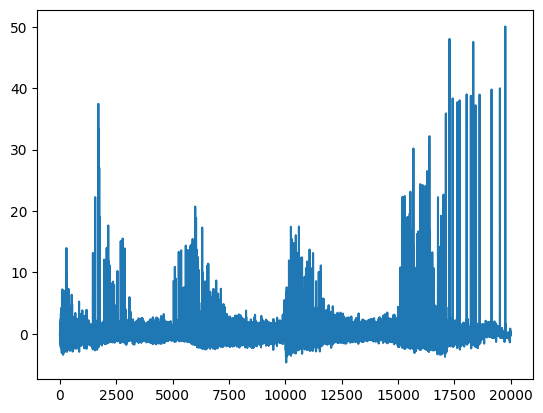

In [9]:
plt.plot(rewards)
plt.show()

In [10]:
d

NameError: name 'd' is not defined

In [ ]:
num_episodes = 1000
episode_rewards = []  # List to store total rewards for each episode

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    total_reward = 0  # Initialize total reward for this episode

    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        total_reward += reward.item()  # Add reward to total reward

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            break

    # Store the total reward for the episode
    episode_rewards.append(total_reward)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


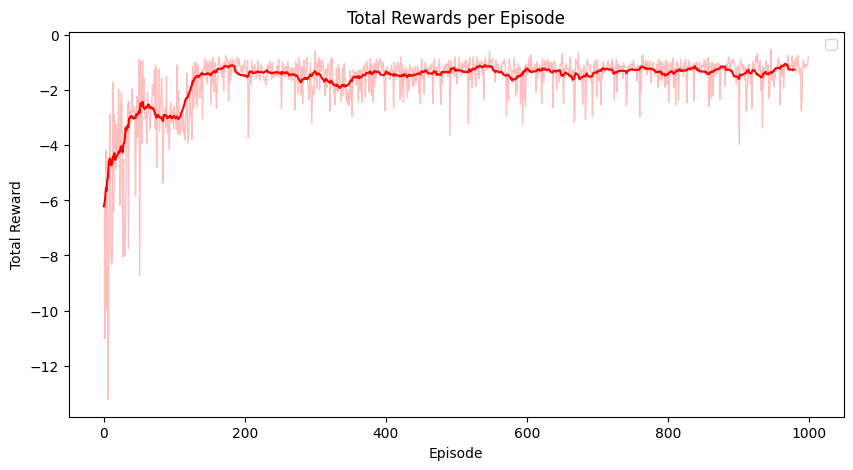

In [ ]:
plt.figure(figsize=(10,5))
smoothing_window = 20
plt.plot([np.mean(episode_rewards[tr:tr+smoothing_window]) for tr in range(len(episode_rewards)-smoothing_window)], color="red")
plt.plot(episode_rewards, linewidth=1, color="red", alpha=0.25)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Rewards per Episode')
plt.legend()
plt.savefig("output/dqn_rewards.png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


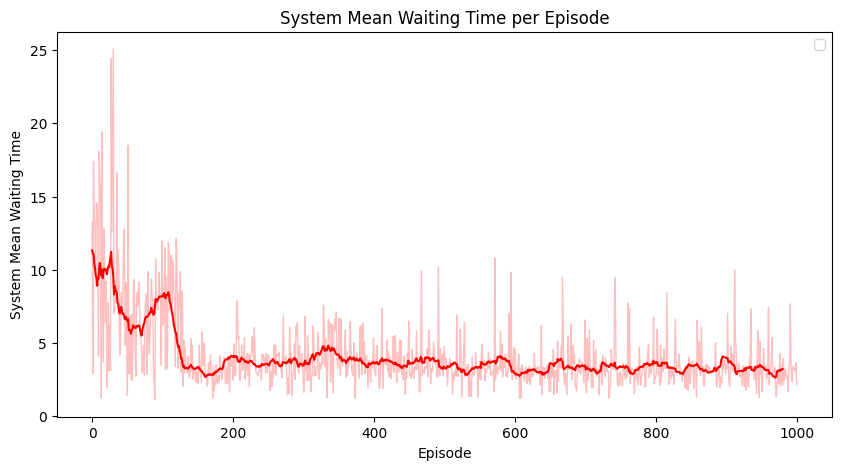

In [ ]:
system_mean_waiting_time_per_episode = [i["system_mean_waiting_time"] for i in info_per_episode]


plt.figure(figsize=(10,5))
smoothing_window = 20
plt.plot([np.mean(system_mean_waiting_time_per_episode[i:i+smoothing_window]) for i in range(len(system_mean_waiting_time_per_episode)-smoothing_window)], color="red")
plt.plot(system_mean_waiting_time_per_episode, linewidth=1, color="red", alpha=0.25)
plt.xlabel('Episode')
plt.ylabel('System Mean Waiting Time')
plt.title('System Mean Waiting Time per Episode')
plt.legend()
plt.savefig("output/dqn_system_mean_waiting_time.png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


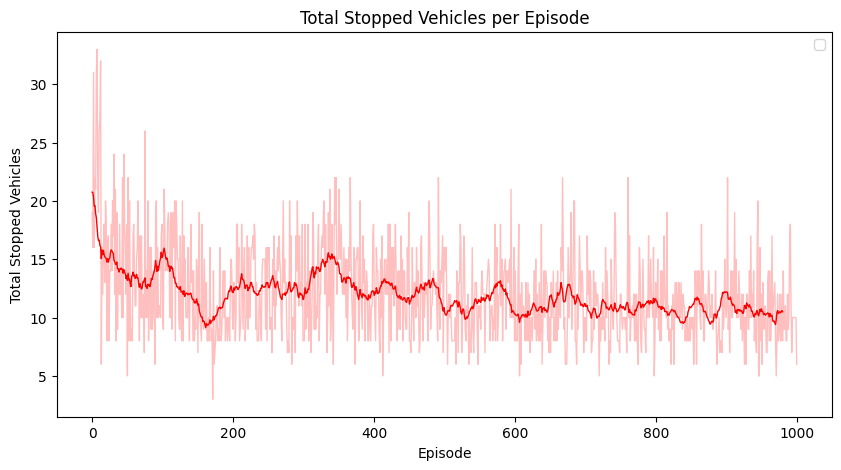

In [ ]:
t_stopped_vehicles_per_episode = [i["t_stopped"] for i in info_per_episode]

plt.figure(figsize=(10,5))
smoothing_window = 20
plt.plot([np.mean(t_stopped_vehicles_per_episode[i:i+smoothing_window]) for i in range(len(t_stopped_vehicles_per_episode)-smoothing_window)], linewidth=1, color="red")
plt.plot(t_stopped_vehicles_per_episode, linewidth=1, color="red", alpha=0.25)
plt.xlabel('Episode')
plt.ylabel('Total Stopped Vehicles')
plt.title('Total Stopped Vehicles per Episode')
plt.legend()
plt.savefig("output/dqn_total_stopped_vehicles.png")

In [ ]:
import json

# save the rewards per episode, system mean waiting time per episode and total stopped vehicles per episode into a json file
with open('results/dqn_results.json', 'w') as fp:
    json.dump({"episode_rewards": episode_rewards, "system_mean_waiting_time_per_episode": system_mean_waiting_time_per_episode, "t_stopped_vehicles_per_episode": t_stopped_vehicles_per_episode}, fp)

In [ ]:
# vizualise the performance of the agent
env = SumoEnvironment(
        net_file="nets/2way-single-intersection/single-intersection.net.xml",
        route_file="nets/2way-single-intersection/single-intersection-vhvh.rou.xml",
        single_agent=True,
        use_gui=True,
        num_seconds=100000,
    )

state, info = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)


# take actions according to the policy network
for t in count():
    action = policy_net(state).max(1).indices.view(1, 1)
    observation, reward, terminated, truncated, info = env.step(action.item())
    reward = torch.tensor([reward], device=device)
    done = terminated or truncated

    if terminated:
        next_state = None
    else:
        next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

    # Move to the next state
    state = next_state

    if done:
        break

 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 6ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds
Step #100.00 (0ms ?*RT. ?UPS, TraCI: 79624ms, vehicles TOT 74 ACT 30 BUF 0)                


FatalTraCIError: Connection closed by SUMO.